In [1]:
import numpy as np
from numpy import *
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MultipleLocator
import pandas as pd
import itertools
import os

# Astropy
from astropy.io import fits
from astropy import units as u
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import ascii

# Fotometría
from photutils import CircularAperture
from photutils import aperture_photometry

# Extincción
 
from extinction import apply
from extinction import fitzpatrick99 as f99
from spectres import spectres

path = os.getcwd()

### Lectura de los datos de la galaxia

Se extraen los datos del archivo fits que es un cubo con su correspondiente header que guarda la información necesaria para estos análisis.

In [2]:
hdul = fits.open('NGC3982.V500.rscube.fits')
hdr = hdul[0].header
img = hdul[0].data
wcs = WCS(hdul[0].header) 
wcs2 = WCS(hdr,naxis=2)

# Se tranforma a longitud de onda cada capa
wave = hdr['CRVAL3'] + hdr['CDELT3']*np.arange(len(img))   

invalid keyvalue. [astropy.wcs.wcs]


### Lectura de las posiciones de las cefeidas empleadas por Riess

Estas se encuentran en el archivo 'riess2016.txt'.

Se crea un dataframe con las posiciones RA y DEC de la galaxia para luego pasarlas a pixeles del cubo de datos.

Luego se eliminan las posiciones que se salgan de la imagen (nuestro campo es un hexágono) teniendo en cuenta la apertura determinada.

In [3]:
datos = pd.read_table(os.path.split(path)[0]+'/riess2016.txt', delim_whitespace=False, sep=',')
galra = datos['RA'][datos['GALAXY'] == 'N3982']    
galdec = datos['DEC'][datos['GALAXY'] == 'N3982']
galpos = pd.concat([galra,galdec], axis=1)

pixel = wcs2.wcs_world2pix(galpos,0)
print(len(pixel))

rapert = 2.5  # Tamaño de la apertura
pixel = np.delete(pixel,np.where((pixel[:,0]<rapert)|(pixel[:,1]<rapert)|
                                 (pixel[:,0]>img.shape[2]-rapert)|
                                 (pixel[:,1]>img.shape[1]-rapert))[0],axis=0)
print(len(pixel))

galpos_final = wcs2.wcs_pix2world(pixel,0)

16
4


### Extracción de los espectros 

El espectro se corresponde con una población estelar, no con la cefeida en sí, pero se emplean dichas posiciones.

Si queda aún alguna cefeida que está fuera del campo se elimina.

Se grafica el espectro integrado.

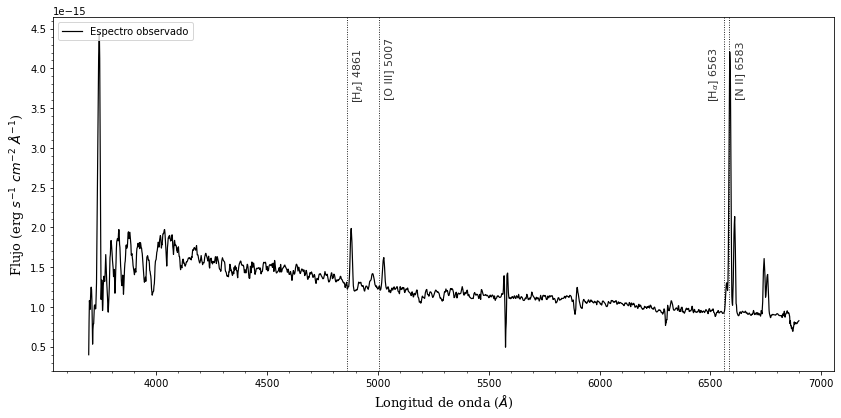

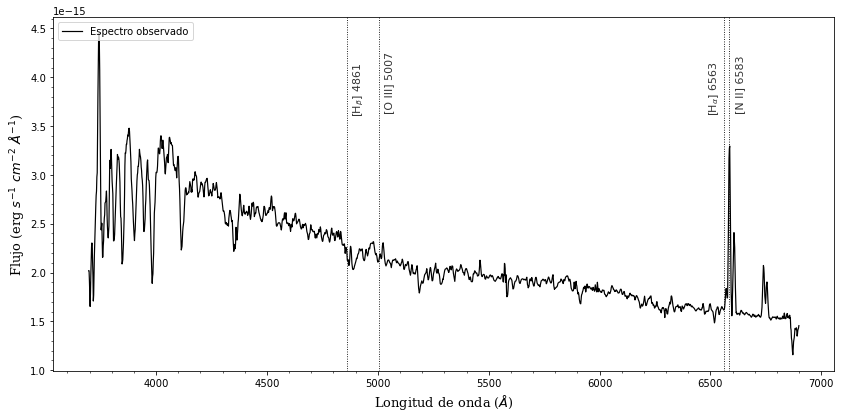

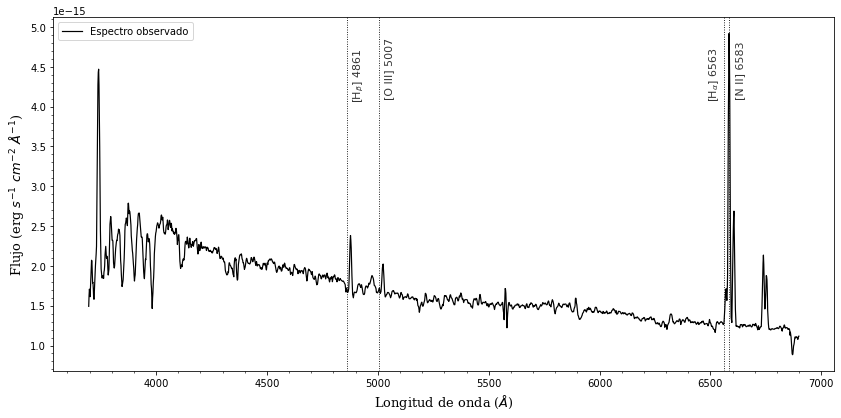

In [4]:
aperture = CircularAperture(pixel, r=rapert)
sp = np.ndarray(shape=(len(img),len(pixel)))
sp_error = np.ndarray(shape=(len(img),len(pixel)))

for i in range(len(img)):     
    data = img[i,:,:]
    apers = [aperture]
    phot_table = aperture_photometry(data, apers)
    sp[i,:] = phot_table['aperture_sum_0']  

        
# Eliminar los que están fuera del hexágono
sp_clean = []
galpos_final_clean = []
for i in range(len(sp[0])):
    if np.isfinite(np.median(sp[:,i])) == 1 and np.median(sp[:,i]) !=0 :
        sp_clean.append(sp[:,i])
        galpos_final_clean.append(galpos_final[i,:])
galpos_final_clean = np.array(galpos_final_clean)

#os.chdir(os.path.split(path)[0]+'/NGC3982')    
#os.getcwd()
#np.savetxt('cefeidas3982.txt', galpos_final_clean)  # se guardan las posiciones finales de las cefeidas
     

# Gráficas
for i in range(len(sp_clean)):
    
    fig, ax = plt.subplots(figsize=(14,6.5))
    #ax.errorbar(wave, sp_clean[i]*10**(-16), yerr=sp_error_clean[i]*10**(-16), 
    #            color='red', linewidth=0.5, alpha=0.8, label='Error')
    ax.plot(wave,sp_clean[i]*10**(-16), linewidth=1.2,color='k',label='Espectro observado')
    
    xlabel(r'Longitud de onda ($\AA$)', fontsize=13,fontfamily='serif')
    ylabel(r'Flujo (erg $s^{-1}$ $cm^{-2}$ $\AA^{-1}$)', fontsize=13,fontfamily='serif') 
    plt.legend(loc='upper left')
    plt.minorticks_on()
    
    axvline(4861, color='k', ls="dotted",lw='0.9')
    text(4881, (sp_clean[i].max()-8)*10**(-16), r'[H$_{\beta}$] 4861',alpha=0.8,rotation='vertical',fontsize='11') 
    axvline(5007, color='k', ls="dotted",lw='0.9')
    text(5027, (sp_clean[i].max()-8)*10**(-16), r'[O III] 5007',alpha=0.8,rotation='vertical',fontsize='11') 
    axvline(6563, color='k', ls="dotted",lw='0.9')
    text(6485, (sp_clean[i].max()-8)*10**(-16), r'[H$_{\alpha}$] 6563',alpha=0.8,rotation='vertical',fontsize='11') 
    axvline(6583, color='k', ls="dotted",lw='0.9')
    text(6613, (sp_clean[i].max()-8)*10**(-16), r'[N II] 6583',alpha=0.8,rotation='vertical',fontsize='11') 
    
    plt.show() 
    
        
## Gráficas de los espectros en las posiciones
#for i in range(len(sp_clean)):        
#    
#    fig, ax = plt.subplots()
#    #ax.errorbar(wave, sp_clean[i]*10**(-16), yerr=sp_error_clean[i]*10**(-16), 
#    #            color='red', linewidth=0.3, alpha=0.7, label='Error')
#    ax.plot(wave,sp_clean[i]*10**(-16), linewidth=0.7,color='k',label='Espectro observado')
#    
#    xlabel(r'Longitud de onda ($\AA$)'); ylabel(r'Flujo (1e-16 erg/s/cm2/A)') 
#    title('Espectro en posición %d' %(i+1))
#    plt.legend()
#    
#    plt.show()   



### Correcciones del espectro

Se obtiene el corrimiento al rojo, z, para cada galaxia en: http://simbad.u-strasbg.fr/simbad/

Y E(B-V) de: https://irsa.ipac.caltech.edu/applications/DUST/

Se corrige la extinción de la galaxia y de la Vía Láctea mediante la ley de extinción de Fitzpatrick (1999). Se utiliza función apply del paquete, que aplica a flujos y no a magnitudes:  

                               flujo = flujo_obs * 10**(0.4 * extinción)

Luego se corrige el corrimiento al rojo, tanto para el espectro como para la longitud de onda:   
 
                                 flujo emitido = (1+z) flujo observado
                         long. de onda emitida = 1/(1+z) long. de onda observada
           


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



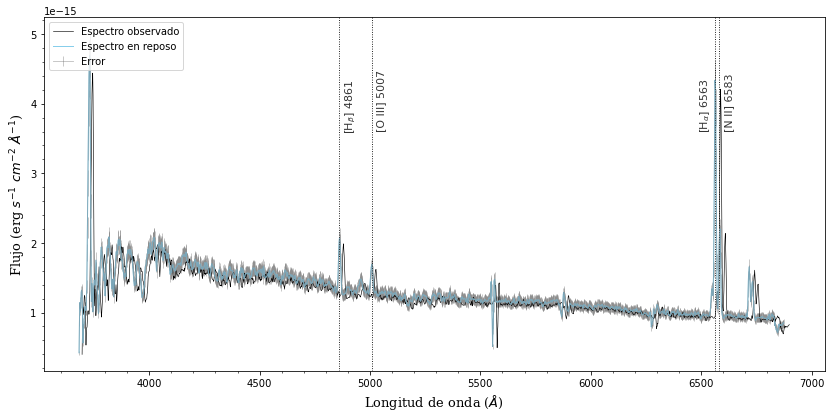

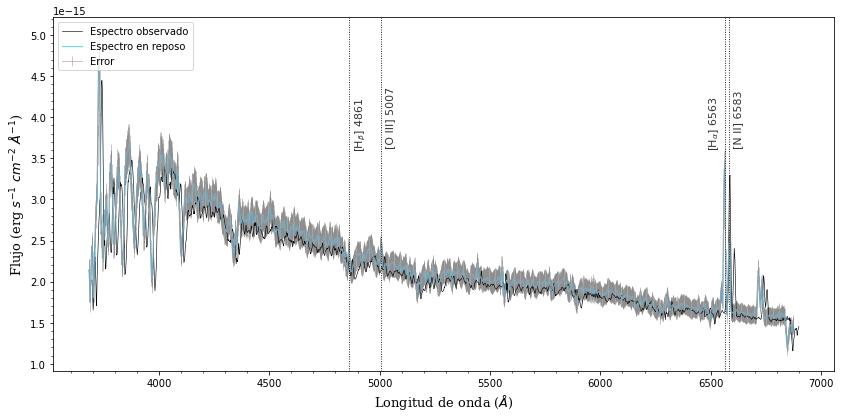

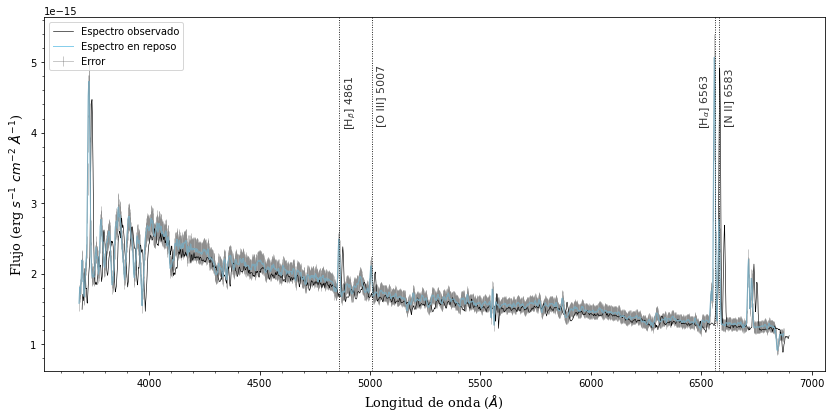

In [5]:
ebv = 0.0122
z = 0.00371


# Correcciones
flux_cor = apply(f99(wave,-3.1*ebv,3.1),sp_clean)
flux_em = flux_cor*(1+z)
wave_em = wave/(1+z)
flux_err=flux_em/15


# Resampling 
x = np.arange(int(np.min(wave_em)+1),7000, 1.)
y = spectres(x, wave_em, flux_em)*10**(-16)
error = spectres(x,wave_em,flux_err)*10**(-16)
x=np.delete(x,np.where(np.isfinite(y)==False),axis=0)
error=np.delete(error,np.where(np.isfinite(y)==False),axis=1)
y=np.delete(y,np.where(np.isfinite(y)==False),axis=1)

            

# Flags
flag = np.zeros(len(x))
bad = np.array([[4350.,4366.],[5453.,5468.],[5565.,5589.],[5883.,5903.],
                [6294.,6306.],[6863.,6937.],[7162.,7333.]])
bad = bad/(1+z)

for i in range(7):
    flag[(x>bad[i,0])&(x<bad[i,1])]=3


# Gráfica 
lenn = len(sp_clean)
for i in range(len(flux_cor)):
    
    fig, ax = plt.subplots(figsize=(14,6.5))
    ax.plot(wave,sp_clean[i]*10**(-16),color='k', linewidth=0.6,label="Espectro observado")
    ax.errorbar(wave_em, flux_em[i]*10**(-16), yerr=flux_err[i]*10**(-16), 
                color='dimgrey', linewidth=0.9, alpha=0.4, label='Error')
    ax.plot(wave_em,flux_em[i]*10**(-16),color='skyblue', linewidth=1,label="Espectro en reposo")
    
    xlabel(r'Longitud de onda ($\AA$)', fontsize=13,fontfamily='serif') 
    ylabel(r'Flujo (erg $s^{-1}$ $cm^{-2}$ $\AA^{-1}$)', fontsize=13,fontfamily='serif') 
    plt.legend(loc='upper left')
    plt.minorticks_on()
    
    axvline(4861, color='k', ls="dotted",lw='0.9')
    text(4881, (sp_clean[i].max()-8)*10**(-16), r'[H$_{\beta}$] 4861',alpha=0.8,rotation='vertical',fontsize='11') 
    axvline(5007, color='k', ls="dotted",lw='0.9')
    text(5027, (sp_clean[i].max()-8)*10**(-16), r'[O III] 5007',alpha=0.8,rotation='vertical',fontsize='11') 
    axvline(6563, color='k', ls="dotted",lw='0.9')
    text(6485,(sp_clean[i].max()-8)*10**(-16), r'[H$_{\alpha}$] 6563',alpha=0.8,rotation='vertical',fontsize='11') 
    axvline(6583, color='k', ls="dotted",lw='0.9')
    text(6603, (sp_clean[i].max()-8)*10**(-16), r'[N II] 6583',alpha=0.8,rotation='vertical',fontsize='11') 
    
    plt.show() 

    
    # Representar y crear tabla para Starlight
    #os.chdir(os.path.split(path)[0]+'/NGC3982/emited_spectrum')
    #os.getcwd()

    
    #table = {'WaveEmit': x, 'FluxEmit': y[i], 'FluxError': error[i], 'Flag':flag}
    #ascii.write(table, 'spectrum_emit_'+str(i)+'_NGC3982.txt', 
    #            formats={ 'WaveEmit': '%.5f','FluxEmit': '%.10e', 'FluxError': '%.10e','Flag': '%d'}, 
    #            overwrite=True,format='fixed_width_no_header', delimiter='') 
    

### Creación de un archivo con las metalicidades 

Para uso futuro se crea un archivo con los datos de metalicidad de Riess en las posiciones correspondientes.

In [19]:
oh = datos['oh'][datos['GALAXY']=='N3982']
data = pd.concat([galpos,oh],axis=1)
data = data.to_numpy()
dataa = np.delete(data,2,1)


def truncate(num,n):
    temp = str(num)
    for x in range(len(temp)):
        if temp[x] == '.':
            try:
                return float(temp[:x+n+1])
            except:
                return float(temp)      
    return float(temp)


dataa_trun = []
for i in range(len(dataa)):
    trun = np.array([truncate(dataa[i,0],3),truncate(dataa[i,1],3)])
    dataa_trun.append(trun)
dataa_trun = np.array(dataa_trun)


galpos_trun = []
for i in range(len(galpos_final_clean)):
    trun = np.array([truncate(galpos_final_clean[i,0],3),truncate(galpos_final_clean[i,1],3)])
    galpos_trun.append(trun)
galpos_trun = np.array(galpos_trun)


m = []
for i in range(len(dataa_trun)):
    if dataa_trun[i,0] in galpos_trun[:,0] and dataa_trun[i,1] in galpos_trun[:,1]:
        oh = data[i,2]
        m.append(oh)               
m_Riess = np.array(m)

os.chdir(os.path.split(path)[0]+'/NGC3982/emited_spectrum')   
os.getcwd()
np.savetxt('m_Riess.txt', m_Riess)